In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import sys, gc, warnings, random, math, time, datetime 
from tqdm import tqdm
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr
import hashlib
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 500
pd.options.display.max_columns = None

import os
print(os.listdir("../input/features/"))

['train_y.pkl', 'train_uid_features.pkl', 'train_features.pkl', 'useful_features.npy', 'test_features.pkl', 'test_uid_features.pkl', 'train_basic_features.pkl', 'rm_features.npy', 'test.pkl', 'test_basic_features.pkl', 'train.pkl']


In [2]:
train = pd.read_pickle('../input/mini-model-data/train_df_s.pkl')
test = pd.read_pickle('../input/mini-model-data/test_df_s.pkl')

train_identity = pd.read_pickle('../input/mini-model-data/train_identity.pkl')
test_identity = pd.read_pickle('../input/mini-model-data/test_identity.pkl')

train = train.merge(train_identity, how='left', left_index=True, right_index=True)
test = test.merge(test_identity, how='left', left_index=True, right_index=True)

train= train.reset_index()
test= test.reset_index()

print(train.shape)
print(test.shape)

(11628, 434)
(11418, 434)


In [3]:
# C
block_users_id = np.load('../input/block_users_id.npy')
block_users_id = []

block_users_id = list(set(block_users_id))

print("black user # ", len(block_users_id))

black user #  0


In [4]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987038,0,87172,25.0,S,5463,399.0,150.0,american express,137.0,credit,330.0,87.0,NaN,98.0,NaN,gmail.com,1.0,2.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,93.0,1.0,0.0,96.0,1.0,542.0,542.0,NaN,NaN,NaN,537.0,4.0,29.000000,0.000000,520.0,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,6.0,1.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,145.0,25.0,0.0,145.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,125.0,25.0,0.0,0.0,25.0,30.0,125.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,145.0,25.0,0.0,145.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,145.0,25.0,0.0,145.0,25.0,0.0,0.0,0.0,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
1,2987069,

In [5]:
# fe with DT
def fe_dt(train_df, test_df, rm_features):

    print('==> processing DT...')
    
    for df in [train_df, test_df]:
        df['DT'] = df['TransactionDT'].apply(
            lambda x: (START_DATE + datetime.timedelta(seconds=x)))
        df['DT_month'] = (df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month
        df['DT_week_year'] = (df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear
        df['DT_day_year'] = (df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear

        df['DT_hour'] = df['DT'].dt.hour
        df['DT_day_week'] = df['DT'].dt.dayofweek
        df['DT_day'] = df['DT'].dt.day
        
#         df['DT_hour_round'] = df['DT_hour'].apply(lambda x: round(x/24))

    rm_features = rm_features

    return train_df, test_df, rm_features
rm_features = []
train, test, rm_features = fe_dt(train, test, rm_features)

==> processing DT...


In [6]:
# fe with W: D 1,2,3,4,5,10,11,15
def fe_d(train_df, test_df, rm_features):
    
    print('==> processing D...')
    
#     d_cols = ['D' + str(i) for i in range(1,16)]
    d_cols = ['D1', 'D2', 'D3', 'D4', 'D5','D6', 'D7', 'D8', 'D10',  'D13', 'D14','D15']

    for df in [train_df, test_df]:        
        for col in d_cols:
            df[col + '_corrected'] = df[col] - df['DT_day_year'] + train_df['DT_day_year'].min()
            df[col + '_corrected'] = df[col + '_corrected'].apply(lambda y: max(0,y))
            df[col + '_corrected'] = df[col + '_corrected'].apply(lambda y: round(y/5))
            
    rm_features = rm_features
    return train_df, test_df, rm_features
# rm_features = []
train, test, rm_features = fe_d(train, test, rm_features)

==> processing D...


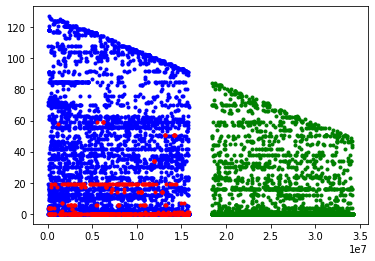

In [7]:
col = 'D1_corrected'
plt.plot(train.set_index('TransactionDT')[train.set_index('TransactionDT').isFraud == 0][col],  '.b')
plt.plot(train.set_index('TransactionDT')[train.set_index('TransactionDT').isFraud == 1][col],  '.r')

plt.plot(test.set_index('TransactionDT')[col],  '.g')


In [8]:
train[train.C1>30]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,DT_month,DT_week_year,DT_day_year,DT_hour,DT_day_week,DT_day,D1_corrected,D2_corrected,D3_corrected,D4_corrected,D5_corrected,D6_corrected,D7_corrected,D8_corrected,D10_corrected,D13_corrected,D14_corrected,D15_corrected
22,2987780,1,102188,10.0,S,8732,360.0,150.0,mastercard,229.0,debit,441.0,87.0,NaN,NaN,NaN,gmail.com,35.0,29.0,0.0,21.0,0.0,5.0,0.0,38.0,0.0,58.0,24.0,0.0,54.0,5.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,0.166626,0.166626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,1.0,5.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,2.0,0.0,0.0,0.0,5.0,1.0,5.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,5.0,2.0,10.0,65.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,65.0,30.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,2.0,2.0,1.0,4.0,1.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,10.0,10.0,0.0,0.0,0.0,10.0,10.0,10.0,0.0,36004.0

In [9]:
train[train.isFraud==1]['D1_corrected'].value_counts()

0     509
19     78
6      21
1      17
14     16
17      9
51      8
4       8
59      4
34      4
16      4
7       4
3       2
58      1
2       1
Name: D1_corrected, dtype: int64

In [10]:
train[train.D1_corrected==19]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,DT_month,DT_week_year,DT_day_year,DT_hour,DT_day_week,DT_day,D1_corrected,D2_corrected,D3_corrected,D4_corrected,D5_corrected,D6_corrected,D7_corrected,D8_corrected,D10_corrected,D13_corrected,D14_corrected,D15_corrected
2,2987188,0,89545,12.0,S,12866,303.0,150.0,visa,226.0,debit,330.0,87.0,NaN,174.0,NaN,NaN,2.0,13.0,0.0,3.0,0.0,1.0,0.0,13.0,0.0,104.0,6.0,0.0,201.0,2.0,94.0,94.0,NaN,NaN,NaN,NaN,NaN,81.000000,0.000000,NaN,NaN,NaN,NaN,NaN,591.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,30.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,277.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0,0.0,4.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,30.0,314.0,75.0,30.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,30.0,67.0,30.0,30.0,67.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,-5.0,15464.0,0.0,0.0,4.0,

In [11]:
for df in [train, test]:
    df['card1'] = df['card1'].fillna(0)
    df['card2'] = df['card2'].fillna(0)
    df['card3'] = df['card3'].fillna(0)
    df['card5'] = df['card5'].fillna(0)
    df['card4'] = df['card4'].fillna('nan')
    df['card6'] = df['card6'].fillna('nan')
    
    df['addr1'] = df['addr1'].fillna(0)
    df['addr2'] = df['addr2'].fillna(0)

In [12]:
def card_info_hash(x):
    s = (str(int(x['card1'])) + str(int(x['card2'])) + str(int(x['card3'])) +
         str(x['card4']) + str(int(x['card5'])) + str(x['card6']))
#     s =  str(x['P_emaildomain'])+str(x['R_emaildomain'])+str(x['id_19'])+str(x['id_20'])

#     s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h


def device_hash(x):
#     s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])

    s = str(x['id_19']) + str(x['id_20']) + str(x['D1_corrected'])

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

In [13]:
%%time

for df in [train, test]:
    df['card_hash'] = df.apply(lambda x: card_info_hash(x), axis=1)
    df['device_hash'] = df.apply(lambda x: device_hash(x), axis=1)

CPU times: user 2.47 s, sys: 216 ms, total: 2.69 s
Wall time: 2.69 s


In [14]:
def get_data_by_card_hash( data, card_hash):
    mask = data['card_hash']==card_hash
    return data.loc[mask,:].copy()

def get_data_by_device_hash( data, device_hash):
    mask = data['device_hash']==device_hash
    return data.loc[mask,:].copy()

def get_data_by_card_and_device_hash( data, card_hash, device_hash):
    mask = (data['card_hash']==card_hash) &(data['device_hash']==device_hash)
    return data.loc[mask,:].copy()

In [15]:
users = train.groupby(['card_hash', 'device_hash'])['isFraud'].agg(['mean', 'count'])

In [16]:
users[(users['mean'] > 0.99) & (users['count']>5) ].head(500)

,,mean,count
card_hash,device_hash,,
0cc046a7ef23817,ad80d289af49a8d,1.0,14
1acdb4c52bab788,ad80d289af49a8d,1.0,8
49cb22f326df6fe,00d89964e2038f1,1.0,7
4eec76b08debf73,ad80d289af49a8d,1.0,14
527dd9f301a567a,b98e26d33fdd1d0,1.0,6
5b7a903fbc6bff5,34a91f86fa182a9,1.0,9
5e6f24ce65ca081,aa531bee0f45f10,1.0,16
798fe912b0f388f,1ac60182083f0b4,1.0,9
a7b9e4828e24f1d,3d9838a8a8ed24c,1.0,9


In [17]:
list_of_interesting_features = [
    'TransactionID',
    'isFraud',
    'card1','card2','card3','card4','card5','card6',
    'TransactionDT',
    'TransactionAmt',
    'ProductCD',
    'device_hash',
    'card_hash',
    'P_emaildomain','R_emaildomain',
    'DT_day_year', 'C1', 'C2', 'dist2', 'DeviceInfo'
] + ['D{}'.format(i) for i in range(1, 16)] +['id_{}'.format(i) for i in [19,20,30,31, 33]]+ ['D{}_corrected'.format(i) for i in [1,2,3,4,5,6,7,8,10,13,14,15]]


inter = get_data_by_card_and_device_hash(train, '72b54c868f8ba62', '270153fc315ae5b')
inter[list_of_interesting_features]

,TransactionID,isFraud,card1,card2,card3,card4,card5,card6,TransactionDT,TransactionAmt,ProductCD,device_hash,card_hash,P_emaildomain,R_emaildomain,DT_day_year,C1,C2,dist2,DeviceInfo,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,id_19,id_20,id_30,id_31,id_33,D1_corrected,D2_corrected,D3_corrected,D4_corrected,D5_corrected,D6_corrected,D7_corrected,D8_corrected,D10_corrected,D13_corrected,D14_corrected,D15_corrected


In [18]:
# BLACK LIST
black_list = users[(users['mean'] > 0.99) & (users['count']>10) ]

for idx in black_list.index:
    mask  = (test.card_hash == idx[0]) & (test.device_hash == idx[1])
    if(mask.sum() > 0):
        print(idx, mask.sum() )
    
    block_users_id = block_users_id  +  list(test.loc[mask,:].TransactionID.values)
    
print("black list id #, ", len(block_users_id), " / ", len(test))

black list id #,  0  /  11418


In [19]:
block_users_id = list(set(block_users_id))

print("black user # ", len(block_users_id))

# np.save('../input/block_users_id', block_users_id)

black user #  0


In [20]:
# sub = pd.read_csv('../input/to_add_black_list.csv', index_col = 'TransactionID')
# sub.loc[block_users_id, 'isFraud'] = 1
# sub.to_csv('../submissions/sub_with_black_list_1.csv', header=True)

In [21]:
# sub.loc[block_users_id, 'isFraud'] 

In [13]:
train[train.isFraud==1][train.V149>15]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,DT_month,DT_week_year,DT_day_year,DT_hour,DT_day_week,DT_day,D1_corrected,D2_corrected,D3_corrected,D4_corrected,D5_corrected,D6_corrected,D7_corrected,D8_corrected,D10_corrected,D13_corrected,D14_corrected,D15_corrected
11357,3565738,1,15421800,30.0,S,6019,583.0,150.0,visa,226.0,credit,441.0,87.0,NaN,NaN,NaN,gmail.com,19.0,18.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,17.0,0.0,0.0,0.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,15.0,15.0,15.0,15.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0,16.0,0.0,17.0,17.0,0.0,0.0,0.0,16.0,0.0,17.0,17.0,17.0,0.0,0.0,0.0,16.0,16.0,16.0,16.0,16.0,16.0,1.0,1.0,15.0,15.0,16.0,16.0,17.0,15.0,15.0,15.0,15.0,15.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,1.0,1.0,1.0,480.0,480.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480.0,480.0,480.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.